In [3]:
import h5py
import numpy as np
import gzip
import matplotlib.pyplot as plt
import os
from lsst.sims.photUtils import BandpassDict, Sed, Bandpass
from lsst.sims.photUtils import cache_LSST_seds, getImsimFluxNorm
from lsst.utils import getPackageDir

_galaxy_sed_dir = os.path.join(getPackageDir('sims_sed_library'))

sed_look_dir = "/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup/"
lookupfile = os.listdir(sed_look_dir)

In [5]:
file_s_e = list()
for i,f in enumerate(lookupfile):
    try:
        look_file = sed_look_dir + f
        hf = h5py.File(look_file, 'r')
        n = hf.get('galaxy_id')
        n = np.array(n)
        file_s_e.append([n[0],n[-1]])
    except:
        print(i,look_file)

57 /global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup/sed_fit_10572.h5


In [20]:
def find_h5_file (gal_id = 1250443219):

    for i,f in enumerate(file_s_e):
        if gal_id > f[0] and gal_id < f[1]:
            if i > 57:
                which_h5file = i + 1
            else:
                which_h5file = i
            print('SED LookupFile: ', lookupfile[which_h5file])
    return(which_h5file)


def find_target_sed(gal_id = 1250443219):
    
    h5f_id = find_h5_file(gal_id=gal_id)
    look_file = sed_look_dir + lookupfile[h5f_id]
    hf = h5py.File(look_file, 'r')
    galaxy_id = hf['galaxy_id'][:]
    bulge_sed = hf['bulge_sed'][:]
    sed_names = hf['sed_names'][:]

    idx = np.where(galaxy_id == gal_id)[0][0]

    target = sed_names[bulge_sed[idx]]
    target_sed = target.decode("utf-8") 
    print('SED template: ',target_sed)
    
    base_spec = Sed()
    base_spec.readSED_flambda(os.path.join(_galaxy_sed_dir, target_sed))
    m = base_spec.wavelen < 1200
    plt.plot(base_spec.wavelen[m],base_spec.flambda[m])
    
    return(target_sed)

SED LookupFile:  sed_fit_8786.h5
SED template:  galaxySED/Inst.62E09.04Z.spec.gz


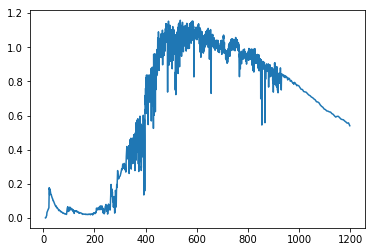

In [21]:
target_sed = find_target_sed(gal_id=1250443219)